In [5]:
from collections import defaultdict

import gseapy as gp
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_colwidth", 200)

import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from scipy.cluster.hierarchy import leaves_list, linkage
from scipy.spatial.distance import pdist, squareform

from scripts import aesthetics
from scripts import manuscript_colors as mc

aesthetics.activate_paper_rcParams('illustrator')

In [6]:
import palettable

Bold_10 = palettable.cartocolors.qualitative.Bold_10.mpl_colors

# GSEA Figures

I was trying to make figures in the general analysis notebook (`analyze_gsea_results`), but that notebook is huge and is asking very high level questions. I wanted to make a notebook where I could just make some figures.

# Read in data

## Category SVs

In [7]:
###########
### SVs ###
###########
category_svs = []
for file in glob.glob("data/CWAS data for Jett/List of variants by category/*.txt"):
    disease = file.split("/")[-1].split("_")[0]

    if disease == "osteosarcoma":
        continue

    sv_category = "noncoding" if "noncoding" in file else "coding"

    cat_svs = pd.read_csv(file, sep="\t").rename(columns={"emd": "end"})
    cat_svs[["disease", "sv_category"]] = [disease, sv_category]
    category_svs.append(cat_svs)

category_svs = pd.concat(category_svs)
category_svs.head(2)

,SV,chrom,start,end,category,disease,sv_category
0,PedSV.2.5.2_DUP_chr1_455,chr1,6720524,6722070,DUP.RARE.PREDICTED_NONCODING_BREAKPOINT.ewing_and_osteosarcoma_atac_peaks.PREDICTED_INTERGENIC.lof_constrained.expressed_in_muscle_skeletal.protein_coding,ewing,noncoding
1,PedSV.2.5.2_DUP_chr1_898,chr1,23649481,23651544,DUP.RARE.PREDICTED_NONCODING_BREAKPOINT.ewing_and_osteosarcoma_atac_peaks.PREDICTED_INTERGENIC.lof_constrained.expressed_in_muscle_skeletal.protein_coding,ewing,noncoding


## Framework results

In [8]:
#########################
### FRAMEWORK RESULTS ###
#########################
framework_results = []
for file in glob.glob("data/CWAS data for Jett/CWAS sum stats/*.txt"):
    if "12_26_23" not in file:
        continue

    disease = file.split("/")[-1].split("_")[0]

    sv_category = "noncoding" if "noncoding" in file else "coding"
    af_category = "singleton" if "SINGLETON" in file else "rare"

    data = pd.read_csv(file, sep="\t")
    data[["disease", "sv_category", "af_category"]] = [
        disease,
        sv_category,
        af_category,
    ]
    framework_results.append(data)

framework_results = pd.concat(framework_results)

In [9]:
num_tests = {
    "neuroblastoma-coding": 279,
    "neuroblastoma-noncoding": 940,
    "ewing-coding": 267,
    "ewing-noncoding": 916,
    "osteosarcoma-coding": 270,
    "osteosarcoma-noncoding": 930
}

bonf_nlp_thresholds = {d: -np.log10(0.05 / n_test) for d, n_test in num_tests.items()}

framework_results["bonferroni_p"] = framework_results.apply(
    lambda row: row["p_value"] * num_tests[row["disease"] + "-" + row["sv_category"]],
    axis=1,
)

framework_results["bonferroni_significant"] = framework_results["bonferroni_p"] < 0.05

In [10]:
framework_schema = defaultdict(dict)
for file in glob.glob("data/CWAS data for Jett/CWAS frameworks/*.txt"):
    if "osteosarcoma" in file:
        continue

    disease = "neuroblastoma" if "neuroblastoma" in file else "ewing"
    sv_category = "noncoding" if "noncoding" in file else "coding"

    data = pd.read_csv(file, sep="\t")
    framework_schema[disease][sv_category] = data

## GSEA results

In [11]:
ref_counts = pd.read_csv("data/cwas-results/reference-counts.csv")

In [12]:
gse_results = pd.read_csv("data/cwas-results/cwas-gene-set-enrichment-results.csv")
binom_results = pd.read_csv("data/cwas-results/cwas-category-gs-binomial-results.csv")

# subset data
gse_results = gse_results[
    gse_results["category"].isin(framework_results["category_name"].tolist())
]
binom_results = binom_results[
    binom_results["category"].isin(framework_results["category_name"].tolist())
]

# reformat and merge
overlap_cols = ["disease", "category", "sv_category", "db", "gs"]
gse_results.columns = [
    c + "_fisher" if c not in overlap_cols else c for c in gse_results.columns
]
binom_results.columns = [
    c + "_binom" if c not in overlap_cols else c for c in binom_results.columns
]

combined_gse_results = gse_results.merge(binom_results, on=overlap_cols).copy()

Add some labels:

In [13]:
category_to_expression = {
    c: c.split(".")[4] if len(c.split(".")) == 6 else c.split(".")[6]
    for c in framework_results["category_name"].tolist()
}
category_to_functional = {
    c: c.split(".")[3] if len(c.split(".")) == 8 else np.nan
    for c in framework_results["category_name"].tolist()
}

combined_gse_results["expression"] = [
    category_to_expression[c] for c in combined_gse_results["category"]
]
combined_gse_results["functional_category"] = [
    category_to_functional[c] for c in combined_gse_results["category"]
]

### Do some prefiltering

In [14]:
combined_gse_results = combined_gse_results[
    combined_gse_results["analysis_fisher"] == "full"
]

# we remove all non GO terms here
combined_gse_results = combined_gse_results[combined_gse_results['db'] == "GO_Biological_Process_Full"]

## Gene sets

In [15]:
# obtained by searching "adrenal gland" on go
adrenal_gs = pd.read_csv('data/adrenal-gene-sets.txt', sep = '\t', header = None, names = ['go', 'gs'])
adrenal_gs = list(adrenal_gs['gs'] + ' (' + adrenal_gs['go'] + ')')

In [16]:
gene_sets = {}
dbs = set()
with open("ref/gene-sets.txt") as gs_in:
    for line in gs_in:
        comp = line.strip().split("\t")
        db = comp[0]
        dbs.add(db)
        gs = comp[1]
        genes = comp[2:]
        
        if db in ['Reactome_2022', 'GO_Biological_Process_Specific']:
            continue
            
        if gs in adrenal_gs:
            gene_sets[f'adrenal | {gs}'] = genes
        
        elif len(genes) >= 30 and len(genes) <= 1000:
            gene_sets[db + " | " + gs] = genes

In [17]:
with open('data/gtex-tissue-specific-gene-sets.txt') as infile:
    for line in infile.readlines():
        line = line.strip()
        tissue = line.split(' | ')[0].lower()
        genes = line.split(' | ')[1].split(',')
        
        gene_sets[f'gtex | {tissue}'] = genes

In [18]:
print(len(gene_sets))

3137


In [19]:
len([g for g in gene_sets if 'GO_Biological_Process_Full' in g])

2722

We are only going to examine GO terms here:

In [20]:
num_effective_gene_sets = 2722
p_bonf_cutoff = 0.05 / 2722

Here's some code just to export for Riaz's review

In [21]:
export = combined_gse_results[['disease', 'category', 'gs', 'sv_category',
                      'ref_freq_cases_fisher', 'cat_freq_cases_fisher', 'p_cases_fisher', 'odds_ratio_cases_fisher', 'num_unique_genes_in_overlap_cases_fisher',
                      'ref_freq_controls_fisher', 'cat_freq_controls_fisher', 'p_controls_fisher', 'odds_ratio_controls_fisher', 'num_unique_genes_in_overlap_controls_fisher']]

export.columns = ['disease', 'category', 'gs', 'sv_category',
                  'outside_cat_freq_cases_fisher', 'inside_cat_freq_cases_fisher', 'p_cases_fisher', 'odds_ratio_cases_fisher', 'num_unique_genes_in_overlap_cases_fisher',
                  'outside_cat_freq_controls_fisher', 'inside_cat_freq_controls_fisher', 'p_controls_fisher', 'odds_ratio_controls_fisher', 'num_unique_genes_in_overlap_controls_fisher']

rename = {'category_name': 'category', 
          'negative_log10_p_value': 'category_negative_log10_p_value', 
          'bonferroni_significant': 'category_bonferroni_significant'}

merged = framework_results[['disease', 'category_name', 'sv_category', 'negative_log10_p_value', 'bonferroni_significant']].rename(columns = rename)
export = merged.merge(export, how = 'right')

for col in ['p_cases_fisher', 'p_controls_fisher']:
    index = list(export.columns).index(col)
    values = export[col] < 0.05 / 2259
    export.insert(index + 1, col + '_bonferroni', values)
    
export.to_csv('gsea-results-export-for-riaz.csv', index=False)

In [22]:
combined_gse_results = merged.merge(combined_gse_results, how = 'right')

# Plot the category results

This is just replicating what Riaz did, for fun

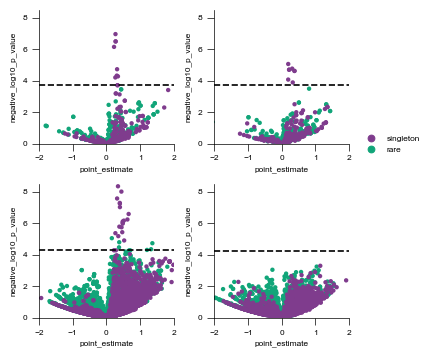

In [23]:
fig, axes = plt.subplots(
    2, 2, figsize=(4, 4), gridspec_kw={"hspace": 0.3, "wspace": 0.3}
)

for i, disease in enumerate(["neuroblastoma", "ewing"]):
    for j, sv_category in enumerate(["coding", "noncoding"]):
        ax = axes[j, i]
        data = framework_results.query(
            f'disease == "{disease}" & sv_category == "{sv_category}"'
        ).sort_values(by="af_category")
        sns.scatterplot(
            x="point_estimate",
            y="negative_log10_p_value",
            data=data,
            ax=ax,
            hue="af_category",
            ec=None,
            hue_order=["singleton", "rare"],
            s=10,
        )
        sns.despine(ax=ax)

        ax.set_ylim([-0.01, 8.5])
        ax.set_xlim([-2, 2])

        # look up threshold
        thresh = bonf_nlp_thresholds[f"{disease}-{sv_category}"]
        ax.axhline(y=thresh, color="black", linestyle="dashed")
        ax.legend().remove()

        if i == 1 and j == 0:
            ax.legend(bbox_to_anchor=(1.05, 0))

We won't pretty them any more than that. Useful to reproduce.

# Plot gene set results for a subset of categories

I like the idea of showing the full spectrum of analyzed gene sets for a category (or a subset of categories, perhaps). Let's first show ALL categories for the diseases.

We're focusing on baseline enrichment here.

Text(0.5, 0, 'odds-ratio')

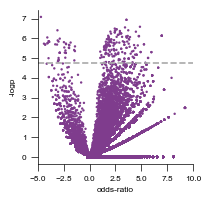

In [24]:
fig, ax = plt.subplots(1, figsize=(2, 2))

data = combined_gse_results.query(
    'disease == "neuroblastoma" & sv_category == "coding"'
).copy()
data["x_baseline"] = np.log2(data["odds_ratio_cases_fisher"])
data["y_baseline"] = -np.log10(data["p_cases_fisher"])

sns.scatterplot(x="x_baseline", y="y_baseline", data=data, s=3, ec=None)
sns.despine(ax=ax)
ax.set_xlim([-5, 10])
ax.axhline(
    y=-np.log10(0.05 / num_effective_gene_sets), linestyle="dashed", color="darkgrey"
)
ax.set_ylabel("-logp")
ax.set_xlabel("odds-ratio")

So pretty hard to interpret. Let's subset down to some example categories

In [25]:
bonferroni_cats = framework_results.query(
    'sv_category == "coding" & bonferroni_significant == True'
)
bonferroni_cats["category_name"].value_counts()

DEL.SINGLETON.ANY.ANY.ANY.protein_coding                                                                     2
ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding                             2
ANY.SINGLETON.ANY.ANY.ANY.protein_coding                                                                     2
DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding                             2
ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.unconstrained.ANY.protein_coding                   1
ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_adrenal_gland.protein_coding      1
ANY.SINGLETON.ANY.unconstrained.ANY.protein_coding                                                           1
ANY.SINGLETON.ANY.ANY.expressed_in_adrenal_gland.protein_coding                                              1
ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_muscle_skeletal.protein_coding    1
A

So a few categories are present in both. I think it makes the most sense to show the top level category, since that's very interesting in terms of baseline findings.

In [26]:
labeled_gs = ['central nervous system development (GO:0007417)', 'positive regulation of synaptic transmission (GO:0050806)',
              'calcium ion homeostasis (GO:0055074)', 'peptide biosynthetic process (GO:0043043)']

[Text(0, 0, '1'), Text(2, 0, '4'), Text(4, 0, '16'), Text(6, 0, '64')]

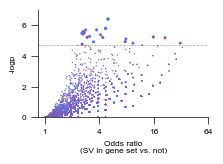

In [27]:
test_cat = "ANY.SINGLETON.ANY.ANY.ANY.protein_coding"

palette = {'neuroblastoma': mc.palette['neuroblastoma']["main"],
           'ewing': mc.palette['ewing']["main"]}

fig, ax = plt.subplots(1, figsize=(2.2, 1.4))

# data = combined_gse_results.query('odds_ratio_cases_fisher > odds_ratio_controls_fisher').copy()
coding_results = combined_gse_results.query('sv_category == "coding" & odds_ratio_cases_fisher > 1').copy()
coding_results["x_baseline"] = np.log2(coding_results["odds_ratio_cases_fisher"])
coding_results["y_baseline"] = -np.log10(coding_results["p_cases_fisher"])

data = coding_results.query(f'category == "{test_cat}"').copy()

nlp_bonf = -np.log10(p_bonf_cutoff)
data['size'] = np.where(data['y_baseline'] > nlp_bonf, 5, 1)
data['c'] = data['disease'].replace(palette)

# plot the significant ones first
sig = data.query(f'y_baseline > {nlp_bonf}')
points = ax.scatter(x = sig['x_baseline'], y = sig['y_baseline'], s = sig['size'], ec = None, c = sig['c'])

# labeled_sig = sig[sig['gs'].isin(labeled_gs)]
# points = ax.scatter(x = labeled_sig['x_baseline'], y = labeled_sig['y_baseline'], s = 10, ec = None, c = 'black')

nonsig = data.query(f'y_baseline < {nlp_bonf}').sample(frac = 1)
for chunk in np.array_split(nonsig, 200):
    zorder = np.random.uniform()
    points = ax.scatter(x = chunk['x_baseline'], y = chunk['y_baseline'], s = chunk['size'], ec = None, c = chunk['c'])

sns.despine(ax=ax)
ax.set_xlim([None, 6])
ax.set_ylim([0, 7])
ax.axhline(
    y=nlp_bonf,
    linestyle="dashed",
    color="darkgrey",
    zorder=-1,
    linewidth = 0.5
)
ax.set_ylabel("-logp")
ax.set_xlabel("Odds ratio\n(SV in gene set vs. not)", fontsize = 6)

ax.set_xticks([0, 2, 4, 6])
ax.set_xticklabels([1, 4, 16, 64])

# ax.legend(bbox_to_anchor = (1, 0.5))

# fig.savefig('images/test-gene-sets-any.pdf')

In [28]:
sig[lambda row: row['gs'].isin(labeled_gs)][['disease', 'gs', 'odds_ratio_cases_fisher', 'p_cases_fisher', 'odds_ratio_controls_fisher', 'p_controls_fisher']]

,disease,gs,odds_ratio_cases_fisher,p_cases_fisher,odds_ratio_controls_fisher,p_controls_fisher
28117,neuroblastoma,positive regulation of synaptic transmission (GO:0050806),21.338921,0.000007,6.771236,0.000008
29058,neuroblastoma,central nervous system development (GO:0007417),2.732646,0.000003,1.607725,0.000006
307851,ewing,calcium ion homeostasis (GO:0055074),7.878173,0.000008,2.602747,0.000002
309444,ewing,peptide biosynthetic process (GO:0043043),4.141723,0.000004,2.310722,0.000003


In [29]:
import scipy

In [30]:
scipy.stats.fisher_exact(np.array([[42, 693 - 42], [78, 3253 - 78]]))

(2.6261373035566584, 3.778416310975297e-06)

Interesting... these do actually differ a little bit. I kind of like that third figure (reduces redundancy between A and B). Can we depict this alone?

What about if we look at the next level down > expressed in adrenal vs. muscle? Do things change?

# Try to visualize some case-control odds ratios

So we've shown that the odd's ratios are up in cases - we have the comparison in controls.

There are a few category-gene set pairs that I'd like to highlight. We also have some that Riaz highlighted for us.

In [31]:
riaz_annotations = pd.read_csv('data/gsea_results_export_for_riaz_bonferroni_significant_annotated_3_12_24.tsv', sep = '\t')

In [32]:
category_geneset_pairs = [['neuroblastoma', 'ANY.SINGLETON.ANY.ANY.ANY.protein_coding', 'central nervous system development (GO:0007417)'],
                          ['neuroblastoma', 'DEL.SINGLETON.ANY.ANY.ANY.protein_coding', 'central nervous system development (GO:0007417)'],
                          ['neuroblastoma', 'DEL.SINGLETON.ANY.ANY.expressed_in_adrenal_gland.protein_coding', 'central nervous system development (GO:0007417)'],
                          ['neuroblastoma', 'ANY.SINGLETON.ANY.ANY.ANY.protein_coding', 'positive regulation of synaptic transmission (GO:0050806)'],
                          ['neuroblastoma', 'DEL.SINGLETON.ANY.ANY.ANY.protein_coding', 'positive regulation of synaptic transmission (GO:0050806)'],
                          ['neuroblastoma', 'DEL.SINGLETON.ANY.ANY.expressed_in_adrenal_gland.protein_coding', 'positive regulation of synaptic transmission (GO:0050806)'],
                          ['ewing', 'ANY.SINGLETON.ANY.ANY.ANY.protein_coding', 'calcium ion homeostasis (GO:0055074)'],
                          ['ewing', 'DEL.SINGLETON.ANY.ANY.ANY.protein_coding', 'calcium ion homeostasis (GO:0055074)'],
                          ['ewing', 'DEL.SINGLETON.ANY.ANY.expressed_in_muscle_skeletal.protein_coding', 'calcium ion homeostasis (GO:0055074)'],
                          ['ewing', 'ANY.SINGLETON.ANY.ANY.ANY.protein_coding', 'peptide biosynthetic process (GO:0043043)'],
                          ['ewing', 'DEL.SINGLETON.ANY.ANY.ANY.protein_coding', 'peptide biosynthetic process (GO:0043043)'],
                          ['ewing', 'DEL.SINGLETON.ANY.ANY.expressed_in_muscle_skeletal.protein_coding', 'peptide biosynthetic process (GO:0043043)'],
                          # ['neuroblastoma', 'ANY.RARE.ANY.ANY.ANY.protein_coding', 'heterochromatin organization (GO:0070828)'],
                          # ['neuroblastoma', 'DEL.RARE.ANY.ANY.ANY.protein_coding', 'heterochromatin organization (GO:0070828)'],
                          # ['neuroblastoma', 'DEL.RARE.ANY.lof_constrained.ANY.protein_coding', 'heterochromatin organization (GO:0070828)']
                         ]

category_geneset_pairs = np.array(category_geneset_pairs)

We also add a calculation for the odds ratio confidence intervals.

In [33]:
import statsmodels.api as sm

In [34]:
def calculate_or_ci(row):
    
    results = []
    for cohort in ['cases', 'controls']:
        top_row = np.array(row[f'cat_freq_{cohort}_fisher'].split('/')).astype(int)
        bottom_row = np.array(row[f'ref_freq_{cohort}_fisher'].split('/')).astype(int)
        
        # adjust to actual counts
        top_row[1] = top_row[1] - top_row[0]
        bottom_row[1] = bottom_row[1] - bottom_row[0]
        
        table = np.array([top_row, bottom_row]).astype(int) + 1
        
        table = sm.stats.Table2x2(table)
        
        odds = table.log_oddsratio
        ci = table.log_oddsratio_confint()
        
        results += [odds] + list(ci)
        
    return results

In [35]:
plot_results = []
log_odds_ratio_intervals = []
for dz, cat, gs in category_geneset_pairs:
    res = combined_gse_results[lambda row: (row['disease'] == dz) & 
                               (row['category'] == cat) & 
                               (row['gs'] == gs) & 
                               (row['sv_category'] == "coding")]

    assert len(res) == 1
    
    log_odds_ratios = calculate_or_ci(res.iloc[0])
    log_odds_ratio_intervals.append(log_odds_ratios)
    
    plot_results.append(res)
    
plot_results = pd.concat(plot_results).reset_index()

# convert from ln to log2
log_odds_ratio_intervals = log_odds_ratio_intervals / np.log(2)

plot_results[['cases_logor', 'cases_logor_upper', 'cases_logor_lower', 'controls_logor', 
              'controls_logor_upper', 'controls_logor_lower']] = log_odds_ratio_intervals

In [36]:
plot_results[['disease', 'category', 'gs', 'ref_freq_cases_fisher', 'cat_freq_cases_fisher', 'odds_ratio_cases_fisher', 'p_cases_fisher', 'cases_logor']]

,disease,category,gs,ref_freq_cases_fisher,cat_freq_cases_fisher,odds_ratio_cases_fisher,p_cases_fisher,cases_logor
0,neuroblastoma,ANY.SINGLETON.ANY.ANY.ANY.protein_coding,central nervous system development (GO:0007417),72/3253,40/693,2.732646,0.000003,1.450299
1,neuroblastoma,DEL.SINGLETON.ANY.ANY.ANY.protein_coding,central nervous system development (GO:0007417),81/3485,31/461,3.083017,0.000003,1.624343
2,neuroblastoma,DEL.SINGLETON.ANY.ANY.expressed_in_adrenal_gland.protein_coding,central nervous system development (GO:0007417),92/3736,20/210,4.309238,0.000001,2.107433
3,neuroblastoma,ANY.SINGLETON.ANY.ANY.ANY.protein_coding,positive regulation of synaptic transmission (GO:0050806),1/3253,8/693,21.338921,0.000007,4.415415
4,neuroblastoma,DEL.SINGLETON.ANY.ANY.ANY.protein_coding,positive regulation of synaptic transmission (GO:0050806),3/3485,6/461,13.366776,0.000152,3.740580
5,neuroblastoma,DEL.SINGLETON.ANY.ANY.expressed_in_adrenal_gland.protein_coding,positive regulation of synaptic transmission (GO:0050806),7/3736,2/210,6.692584,0.079273,2.742563
6,ewing,ANY.SINGLETON.ANY.ANY.ANY.protein_coding,calcium ion homeostasis (GO:0055074),6/3109,13/800,7.878173,0.000008,2.977861
7,ewing,DEL.SINGLETON.ANY.ANY.ANY.protein_coding,calcium ion homeostasis (GO:0055074),12/3368,7/541,3.861395,0.010452,1.949122
8,ewing,DEL.SINGLETON.ANY.ANY.expressed_in_muscle_skeletal.protein_coding,calcium ion homeostasis (GO:0055074),16/3686,3/223,3.908438,0.090411,1.966592
9,ewing,ANY.SINGLETON.ANY.ANY.ANY.protein_coding,peptide biosynthetic process (GO:0043043),22/3109,23/800,4.141723,0.000004,2.050231


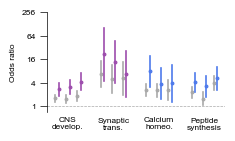

In [37]:
fig, ax = plt.subplots(1, figsize = (2.3, 1.3)) 
                         # gridspec_kw = {'hspace': 0.1, 'height_ratios': [1, 0.2]}, sharex = True)

x = 0
xticks = []
for index, row in plot_results.iterrows():
    dz = row['disease']
    
    for cohort in ['controls', 'cases']:
        
        color = palette[dz] if cohort == "cases" else "darkgrey"
        
        y_val = row[f'{cohort}_logor']
        y_upper = row[f'{cohort}_logor_upper']
        y_lower = row[f'{cohort}_logor_lower']
        ax.scatter([x], [y_val], s = 4, color = color)
        ax.plot([x, x], [y_upper, y_lower], color = color)
    
        if cohort == 'controls':
            xticks.append(x + 0.4)

        x += 0.8

    x += 1
    
    if (index + 1) % 3 == 0:
        x += 3
        
ax.set_yticks([-2, 0, 2, 4, 6, 8])
ax.set_yticklabels([0.25, 1, 4, 16, 64, 256])
ax.set_ylim([-0.5, 8])
ax.axhline(y = 0, color = 'darkgrey', linestyle = 'dashed', zorder = -1, linewidth = 0.5)
aesthetics.strip_axis(ax, x = 'label', y = 'ignore')
ax.set_ylabel('Odds ratio')
ax.set_xticks(xticks[1::3])
ax.set_xticklabels(['CNS\ndevelop.', 'Synaptic\ntrans.', 'Calcium\nhomeo.', 'Peptide\nsynthesis'], fontsize = 6)

# add the "legend" component
# ax = axes[1]
# ax.set_ylim([-0.5, 4])

# for i, x in enumerate(xticks):
#     ax.scatter([x], [3], s = 3, color = 'darkgrey')
    
# aesthetics.strip_axis(ax = ax, x = 'label')
    
# ax.scatter(xticks, [0.5] * len(xticks))
# ax.set_xticks(xticks)
# ax.set_xticklabels(['CNS\ndevelop.', 'synaptic\ntrans.', 'protein\ndepolym.', 'actin\ncytoskeleton'], fontsize = 6)
# ax.text(x = 0.5, y = 1.1, s = 'singletons > deletions > expressed in tissue', transform = ax.transAxes, ha = 'center', va = 'bottom')

fig.savefig('images/gene-set-odds-ratios.pdf')

In [38]:
sig.query('disease == "ewing"')[['gs', 'odds_ratio_cases_fisher', 'p_cases_fisher', 'odds_ratio_controls_fisher', 'p_controls_fisher']]

,gs,odds_ratio_cases_fisher,p_cases_fisher,odds_ratio_controls_fisher,p_controls_fisher
307602,intracellular monoatomic cation homeostasis (GO:0030003),4.704428,1.627401e-06,1.849114,0.000028
307851,calcium ion homeostasis (GO:0055074),7.878173,8.000282e-06,2.602747,0.000002
307904,metal ion transport (GO:0030001),2.828269,2.069576e-06,1.361625,0.008281
308037,regulation of cold-induced thermogenesis (GO:0120161),9.435949,1.502535e-05,2.797607,0.000301
308170,amide biosynthetic process (GO:0043604),3.461394,1.235680e-05,2.806981,0.000003
308557,feeding behavior (GO:0007631),31.335013,1.472561e-05,6.811041,0.000020
308813,monoatomic ion homeostasis (GO:0050801),4.998381,4.085961e-07,2.020081,0.000003
309344,intracellular monoatomic ion homeostasis (GO:0006873),4.704428,1.627401e-06,1.846034,0.000020
309444,peptide biosynthetic process (GO:0043043),4.141723,4.271247e-06,2.310722,0.000003
309725,monoatomic cation homeostasis (GO:0055080),4.998381,4.085961e-07,2.053854,0.000002


In [39]:
paths = {'lof_constrained': 'data/CWAS data for Jett/lof_constrained_genes_7_31_23 (1).txt',
         'missense_constrained': 'data/CWAS data for Jett/missense_constrained_genes_7_31_23.txt',
         'unconstrained': 'data/CWAS data for Jett/unconstrained_genes_7_31_23.txt',
         'expressed_in_adrenal_gland': 'data/CWAS data for Jett/top_expressed_in_adrenal_gland_7_31_23 (1).txt',
         'protein_coding': 'data/CWAS data for Jett/gencode_hg38_protein_coding_genes_for_annotation_7_31_23 (1).txt',
         'cosmic_and_germline_CPGs': 'data/CWAS data for Jett/cosmic_cancer_genes_tier_one_and_germline_CPGs_10_23_23 (1).txt',
         'expressed_in_muscle_skeletal': 'data/CWAS data for Jett/top_expressed_in_muscle_skeletal_7_31_23.txt'}

gene_restrictions = {}
for label, path in paths.items():
    data = pd.read_csv(path)
    data = data[~data['value'].str.startswith('ENSG00')]
    data = data['value'].tolist()

    gene_restrictions[label] = data

In [40]:
gene_sets_ref = ['GO_Biological_Process_Full | central nervous system development (GO:0007417)', 
                 'GO_Biological_Process_Full | positive regulation of synaptic transmission (GO:0050806)']

gene_sets_test = ['expressed_in_adrenal_gland',
                  'gtex | adrenal-gland-rank-100', 'gtex | adrenal-gland-exp-100',
                  'gtex | adrenal-gland-rank-200', 'gtex | adrenal-gland-exp-200',
                  'gtex | adrenal-gland-rank-500', 'gtex | adrenal-gland-exp-500']

for gs in gene_sets_test:
    print(gs)
    if gs == 'expressed_in_adrenal_gland':
        test_genes = gene_restrictions['expressed_in_adrenal_gland']
    else:
        test_genes = gene_sets[gs]
        
    for gs_test in gene_sets_ref:
        test_genes_2 = gene_sets[gs_test]
        
        overlap_gs = len(set(test_genes_2) & set(test_genes)) / len(test_genes)
        overlap_ref = len(set(test_genes_2) & set(gene_ref)) / len(gene_ref)
        # compare
        print(overlap_gs, overlap_ref)
        
    print('----')


test = gene_sets['GO_Biological_Process_Full | central nervous system development (GO:0007417)']
test2 = gene_sets['GO_Biological_Process_Full | positive regulation of synaptic transmission (GO:0050806)']
adrenal = gene_restrictions['expressed_in_adrenal_gland']

print(len(test), len(adrenal), len(set(test) & set(adrenal)))
print(len(test), len(gene_ref), len(set(test) & set(gene_ref)))

expressed_in_adrenal_gland


NameError: name 'gene_ref' is not defined

# Try to make a heat map

I've futzed around with the above to recognize that it isn't particularly helpful. It's just so amorphous and difficult to label.

A heatmap offers us the ability to show a subset of categories and a subset of gene sets. I think this is pretty helpful. Let's start by just showing the bonferroni significant categories - and within those, only the gene sets that are significant in each.

In [227]:
sig_gene_sets = {}
for disease in ['neuroblastoma', 'ewing']:
    sig_categories = framework_results.query(
        f'bonferroni_significant & sv_category == "coding" & disease == "{disease}"' 
    )
    sig_categories = list(
        sig_categories["disease"] + " | " + sig_categories["category_name"]
    )

    heatmap_data = coding_results.copy()
    heatmap_data["disease_category"] = (
        heatmap_data["disease"] + " | " + heatmap_data["category"]
    )
    heatmap_data = heatmap_data[heatmap_data["disease_category"].isin(sig_categories)]

    # gene_sets_to_show = list(heatmap_data[heatmap_data['y_baseline'] > 4]['gs'].unique())
    gene_sets_to_show = heatmap_data[
        (heatmap_data["y_baseline"] > -np.log10(0.05 / num_effective_gene_sets)) & \
        (heatmap_data['x_baseline'] > 0)
    ]

    gene_sets_to_show = gene_sets_to_show['gs'].value_counts()

    # only show hits significant in at least 2 categories
    gene_sets_to_show = list(gene_sets_to_show[gene_sets_to_show > 1].index)
    
    if disease == 'ewing':
        gene_sets_to_show += ['calcium ion homeostasis (GO:0055074)']

    heatmap_values = heatmap_data[heatmap_data["gs"].isin(gene_sets_to_show)]

    heatmap_p = heatmap_values.pivot(
        index="disease_category", columns="gs", values="y_baseline"
    )

    heatmap_values = heatmap_values.pivot(
        index="disease_category", columns="gs", values="x_baseline"
    )

    heatmap_values = heatmap_values.loc[sig_categories].T
    heatmap_p = heatmap_p.loc[sig_categories].T
    
    sig_gene_sets[disease] = [heatmap_values, heatmap_p]
    
    print(disease, len(heatmap_values))

neuroblastoma 18
ewing 16


## Order the categories and gene sets

These gene sets and categories are redundant with each other. We should clearly order them by overlap.

### Order categories

The categories should pretty clearly be ordered by hierarchy.

In [228]:
category_order = {'neuroblastoma': ["neuroblastoma | ANY.SINGLETON.ANY.ANY.ANY.protein_coding",
    "neuroblastoma | ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding",
    "neuroblastoma | ANY.SINGLETON.ANY.ANY.expressed_in_adrenal_gland.protein_coding",
    "neuroblastoma | DEL.SINGLETON.ANY.ANY.ANY.protein_coding",
    "neuroblastoma | ANY.SINGLETON.ANY.unconstrained.ANY.protein_coding",
    "neuroblastoma | DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding",
    "neuroblastoma | ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_adrenal_gland.protein_coding",
    "neuroblastoma | ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.unconstrained.ANY.protein_coding"],
                  "ewing": ["ewing | ANY.SINGLETON.ANY.ANY.ANY.protein_coding",
    "ewing | ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding",
    "ewing | DEL.SINGLETON.ANY.ANY.ANY.protein_coding",
    "ewing | ANY.SINGLETON.ANY.ANY.expressed_in_muscle_skeletal.protein_coding",
    "ewing | DEL.SINGLETON.ANY.ANY.expressed_in_muscle_skeletal.protein_coding",
    "ewing | DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding",
    "ewing | ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_muscle_skeletal.protein_coding",
    "ewing | DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_muscle_skeletal.protein_coding"]
                 }

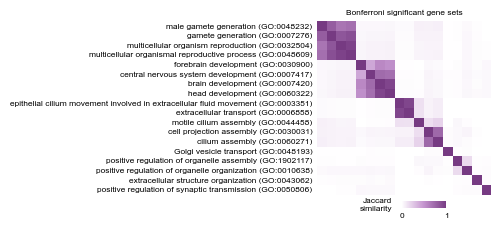

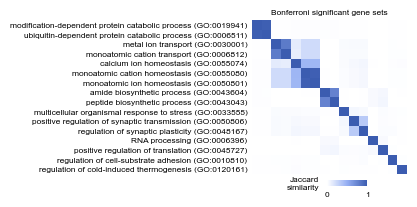

In [229]:
jaccard_matrices = {}
for disease in ['neuroblastoma', 'ewing']:
    
    gene_sets_to_show = sig_gene_sets[disease][0].index

    gs_list = []
    genes_list = []

    for gs, genes in gene_sets.items():
        gs = gs.split(" | ")[1]
        if gs not in gene_sets_to_show:
            continue
        gs_list += [gs] * len(genes)
        genes_list += genes

    gs_gene_matrix = pd.DataFrame()
    gs_gene_matrix["gs"] = gs_list
    gs_gene_matrix["gene"] = genes_list
    gs_gene_matrix["value"] = 1

    gs_gene_matrix = (
        gs_gene_matrix.pivot(columns="gs", index="gene", values="value").fillna(0).T
    )

    data_values = gs_gene_matrix.values.astype(bool)

    j_dist = pdist(data_values, metric="jaccard")
    j_dist = 1 - squareform(j_dist)

    Z = linkage(j_dist, method="average")
    ordered_indices = leaves_list(Z)

    ordered_gs = gs_gene_matrix.index[ordered_indices]

    j_dist = j_dist[ordered_indices, :][:, ordered_indices]
    j_dist = pd.DataFrame(j_dist, index=ordered_gs, columns=ordered_gs);
    
    # make the color map
    custom_cmap = colors.LinearSegmentedColormap.from_list('custom', ['white', mc.palette[disease]['light2'], mc.palette[disease]['dark1']], N = 256)
    
    fig, ax = plt.subplots(1, figsize=np.array([0.125, 0.125]) * len(ordered_gs))
    sns.heatmap(j_dist, annot=False, cmap=custom_cmap, cbar=False)
    ax.set_yticks(np.array(range(len(ordered_gs))) + 0.5)
    ax.set_yticklabels(ordered_gs, fontsize = 6, va = 'center')
    ax.set_xticklabels([])
    ax.tick_params(axis = 'both', length = 0)
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.text(s = 'Bonferroni significant gene sets', x = 0.5, y = 1.03, transform = ax.transAxes, ha = 'center', va = 'bottom')
    
    # add the colorbar
    cb = mpl.cm.ScalarMappable(cmap=custom_cmap)

    cbar_ax = fig.add_axes([0.5, 0.05, 0.2, 0.03])
    cbar = fig.colorbar(cb, cax=cbar_ax, orientation='horizontal')
    cbar.ax.tick_params(size=0)
    cbar.outline.set_visible(False)
    cbar_ax.text(s = 'Jaccard\nsimilarity', x = -0.2, y = 0.5, ha = 'right', va = 'center')
    
    fig.savefig(f'images/{disease}-gene-set-jaccard.pdf', bbox_inches = 'tight')

In [230]:
# category_order = []
# for disease in ["neuroblastoma", "ewing"]:
#     order_data = category_svs.query(
#         f'disease == "{disease}" & sv_category == "coding"'
#     ).copy()
#     order_data["disease_category"] = (
#         order_data["disease"] + " | " + order_data["category"]
#     )

#     order_data = order_data[(order_data["disease_category"].isin(sig_categories))]
#     order_data["value"] = 1

#     # get the actual SVs present in cases
#     svs_in_cases = list(
#         set(
#             ref_counts.query(
#                 f'sv_category == "coding" & disease == "{disease}" & cohort == "case" & dose > 0'
#             )["name"]
#         )
#     )
#     order_data = order_data[order_data["SV"].isin(svs_in_cases)]

#     order_data_pivoted = order_data.pivot(
#         columns="SV", index="disease_category", values="value"
#     ).fillna(0)

#     data_values = order_data_pivoted.values.astype(bool)

#     j_dist = pdist(data_values, metric="jaccard")
#     j_dist = 1 - squareform(j_dist)

#     Z = linkage(j_dist, method="average")
#     ordered_indices = leaves_list(Z)

#     ordered_categories = order_data_pivoted.index[ordered_indices]
#     print(ordered_categories)

#     category_order += list(ordered_categories)

We drop some gene sets here:

In [231]:
# dropped_gs = [
#     "female pregnancy (GO:0007565)",
#     "epithelial cilium movement involved in extracellular fluid movement (GO:0003351)",
#     "extracellular transport (GO:0006858)",
#     "motile cilium assembly (GO:0044458)",
#     "cell projection assembly (GO:0030031)",
#     "cilium assembly (GO:0060271)",
#     "negative regulation of protein-containing complex assembly (GO:0031333)",
#     "female gamete generation (GO:0007292)",
#     "ovarian follicle development (GO:0001541)",
#     "regulation of cell-substrate adhesion (GO:0010810)",
#     'regulation of protein depolymerization (GO:1901879)',
#     'developmental growth (GO:0048589)'
# ]

In [232]:
category_order = [
    "neuroblastoma | ANY.SINGLETON.ANY.ANY.ANY.protein_coding",
    "neuroblastoma | DEL.SINGLETON.ANY.ANY.ANY.protein_coding",
    "neuroblastoma | DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding",
    "neuroblastoma | ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding",
    "neuroblastoma | ANY.SINGLETON.ANY.unconstrained.ANY.protein_coding",
    "neuroblastoma | ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_adrenal_gland.protein_coding",
    "neuroblastoma | ANY.SINGLETON.ANY.ANY.expressed_in_adrenal_gland.protein_coding",
    "neuroblastoma | ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.unconstrained.ANY.protein_coding",
    "ewing | ANY.SINGLETON.ANY.ANY.ANY.protein_coding",
    "ewing | DEL.SINGLETON.ANY.ANY.ANY.protein_coding",
    "ewing | ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding",
    "ewing | DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding",
    "ewing | DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_muscle_skeletal.protein_coding",
    "ewing | DEL.SINGLETON.ANY.ANY.expressed_in_muscle_skeletal.protein_coding",
    "ewing | ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_muscle_skeletal.protein_coding",
    "ewing | ANY.SINGLETON.ANY.ANY.expressed_in_muscle_skeletal.protein_coding",
]

Drop some gene sets and some categories (I dislike the unconstrained categories)

In [291]:
# ordered_gs = [gs for gs in ordered_gs if gs not in dropped_gs]
# category_order = [cat for cat in category_order if 'unconstrained' not in cat]

gs_names = ['Forebrain', 'CNS', 'Brain', 'Head', 'Transmission', 'Plasticity', 'Metal ions', 'Cations', 'Calcium', 'Amide', 'Peptide']

ordered_gs = ['forebrain development (GO:0030900)',
 'central nervous system development (GO:0007417)',
 'brain development (GO:0007420)',
 'head development (GO:0060322)',
             'positive regulation of synaptic transmission (GO:0050806)',
 'regulation of synaptic plasticity (GO:0048167)',
             'metal ion transport (GO:0030001)',
 'monoatomic cation transport (GO:0006812)',
             'calcium ion homeostasis (GO:0055074)',
             'amide biosynthetic process (GO:0043604)',
             'peptide biosynthetic process (GO:0043043)']

gs_to_name = dict(zip(ordered_gs, gs_names))

In [292]:
traits = ['expressed_in_',
 'PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP',
          'unconstrained',
 'DEL']
trait_names = ['Gene expressed in\ntissue of origin', 'LoF SV', 'Unconstrained', 'Deletion']
trait_matrix = []
for t in traits:
    row = []
    for c in category_order:
        value = 1 if t in c else 0
        row.append(value)
        
    trait_matrix.append(row)
    
trait_matrix = pd.DataFrame(trait_matrix, columns = category_order, index = traits)

In [293]:
trait_matrix

,neuroblastoma | ANY.SINGLETON.ANY.ANY.ANY.protein_coding,neuroblastoma | DEL.SINGLETON.ANY.ANY.ANY.protein_coding,neuroblastoma | DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding,neuroblastoma | ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding,neuroblastoma | ANY.SINGLETON.ANY.unconstrained.ANY.protein_coding,neuroblastoma | ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_adrenal_gland.protein_coding,neuroblastoma | ANY.SINGLETON.ANY.ANY.expressed_in_adrenal_gland.protein_coding,neuroblastoma | ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.unconstrained.ANY.protein_coding,ewing | ANY.SINGLETON.ANY.ANY.ANY.protein_coding,ewing | DEL.SINGLETON.ANY.ANY.ANY.protein_coding,ewing | ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding,ewing | DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding,ewing | DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_muscle_skeletal.protein_coding,ewing | DEL.SINGLETON.ANY.ANY.expressed_in_muscle_skeletal.protein_coding,ewing | ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_muscle_skeletal.protein_coding,ewing | ANY.SINGLETON.ANY.ANY.expressed_in_muscle_skeletal.protein_coding
expressed_in_,0,0,0,0,0,1,1,0,0,0,0,0,1,1,1,1
PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP,0,0,1,1,0,1,0,1,0,0,1,1,1,0,1,0
unconstrained,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
DEL,0,1,1,0,0,0,0,0,0,1,0,1,1,1,0,0


Alright, let's make this sucker.

In [294]:
groupings = {'neurodevelopment': ['forebrain development (GO:0030900)',
                                  'central nervous system development (GO:0007417)',
                                  'brain development (GO:0007420)',
                                  'head development (GO:0060322)'],
             'synapse': ['positive regulation of synaptic transmission (GO:0050806)',
                                 'regulation of synaptic plasticity (GO:0048167)'],
             'ion biology': ['metal ion transport (GO:0030001)',
                             'monoatomic cation transport (GO:0006812)',
                             'calcium ion homeostasis (GO:0055074)'],
             'biosynthesis': ['amide biosynthetic process (GO:0043604)',
                              'peptide biosynthetic process (GO:0043043)']}

In [295]:
from matplotlib import colors

In [296]:
cmaps = {dz: colors.LinearSegmentedColormap.from_list('custom', ['white', mc.palette[dz]['light2'], mc.palette[dz]['dark1']], N = 256) for dz in ['neuroblastoma', 'ewing']}

In [297]:
sig_gene_sets_total = sorted(set(sig_gene_sets['neuroblastoma'][0].index.tolist() + sig_gene_sets['ewing'][0].index.tolist()))

In [298]:
# we need to get data for all the significant gene sets, unfortunately
total_heatmap_data = coding_results.copy()
total_heatmap_data["disease_category"] = (
    total_heatmap_data["disease"] + " | " + total_heatmap_data["category"]
)
total_heatmap_data = total_heatmap_data[total_heatmap_data["disease_category"].isin(category_order)]

total_heatmap_values = total_heatmap_data[total_heatmap_data["gs"].isin(sig_gene_sets_total)]

total_heatmap_p = total_heatmap_values.pivot(
    index="disease_category", columns="gs", values="y_baseline"
)

total_heatmap_values = total_heatmap_values.pivot(
    index="disease_category", columns="gs", values="x_baseline"
)

total_heatmap_values = total_heatmap_values.loc[category_order].T
total_heatmap_p = total_heatmap_p.loc[category_order].T

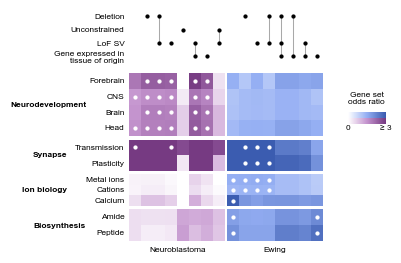

In [325]:
fig = plt.figure(figsize=(2.5, 3), tight_layout=False)
gs = fig.add_gridspec(6, 2, hspace = 0.1, wspace = 0.02, width_ratios = [8, 8], 
                       height_ratios = [1.7, 0.1, 2, 1, 1, 1])

# plot the category "labels"
cat_axes = []
for k, disease in enumerate(['neuroblastoma', 'ewing']):
    ax = fig.add_subplot(gs[0, k])
    cat_axes.append(ax)
    
    disease_cols = [c for c in trait_matrix.columns if disease in c]
    subtrait_matrix = trait_matrix.loc[:, disease_cols]

    for j in range(subtrait_matrix.shape[1]):

        connections = []

        for i in range(subtrait_matrix.shape[0]):
            val = subtrait_matrix.iloc[i, j]
            if val == 1:
                ax.scatter([j + 0.5], [i + 0.5], color = 'black', s = 5)
                connections.append(i + 0.5)

        # plot connecting lines
        if connections:
            ax.plot([j + 0.5] * len(connections), connections, color = 'darkgrey', zorder = 0, linewidth = 0.75)
            
    ax.set_ylim([0, 4])
    ax.set_xlim([0, subtrait_matrix.shape[1]])
    
    if k == 0:
        ax.set_yticks(np.arange(0, len(traits)) + 0.5)
        ax.set_yticklabels(trait_names, fontsize = 6)
        aesthetics.strip_axis(ax, y = 'label')
    else:
        aesthetics.strip_axis(ax)

# plot by each group - 3 x 2
ylabel_offsets = {'neurodevelopment': -0.45, 'synapse': -0.65, 'ion biology': -0.65, 'biosynthesis': -0.45}
for i, (g, g_gene_sets) in enumerate(groupings.items()):
    row = i + 2
    
    for j, disease in enumerate(['neuroblastoma', 'ewing']):
        sharex = cat_axes[j]
        ax = fig.add_subplot(gs[row, j], sharex = sharex)
        
        # get the data
        disease_cols = [c for c in category_order if disease in c]
        subheatmap = total_heatmap_values.loc[g_gene_sets, disease_cols]
        
        ax.set_xlim([0, len(disease_cols)])
        
        sns.heatmap(
            subheatmap,
            ax=ax,
            cmap=cmaps[disease],
            vmin=0,
            vmax=3,
            cbar = None
        )
        
        ax.set_yticks(np.arange(0, len(g_gene_sets)) + 0.5)
        
        for row_i, cat in enumerate(disease_cols):
            for row_j, sub_gs in enumerate(g_gene_sets):

                y_baseline = total_heatmap_p.loc[sub_gs, cat]
                if y_baseline > -np.log10(0.05 / num_effective_gene_sets):
                    ax.scatter([row_i + 0.5], [row_j + 0.5], s = 5, color = 'white')
                    
        if j != 0:
            aesthetics.strip_axis(ax)
        
        else:
            names = [gs_to_name[sub_gs] for sub_gs in g_gene_sets]
            ax.set_yticklabels(names, rotation = 0, fontsize = 6)
            ax.tick_params(axis = 'both', length = 0)
            ax.set_xticks([])
            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.text(s = g.capitalize(), x = ylabel_offsets[g], y = 0.5, ha = 'right', 
                    va = 'center', transform = ax.transAxes, weight = 'bold')
            
        if i == 3:
            ax.text(s = disease.capitalize(), x = 0.5, y = -0.2, transform = ax.transAxes, va = 'top', ha = 'center')
    
norm = mpl.colors.Normalize(vmin=0, vmax=3)
nbl_cb = mpl.cm.ScalarMappable(norm=norm, cmap=cmaps['neuroblastoma'])
ews_cb = mpl.cm.ScalarMappable(norm=norm, cmap=cmaps['ewing'])

for i, cb in enumerate([nbl_cb, ews_cb]):

    cbar_ax = fig.add_axes([1, 0.5 + 0.02 * i, 0.15, 0.02])
    cbar = fig.colorbar(cb, cax=cbar_ax, orientation='horizontal')

    cbar.ax.tick_params(size=0)
    
    if i == 0:
        cbar.ax.set_xticklabels([])
    else:
        cbar.ax.set_xticks([0, 3])
        cbar.ax.set_xticklabels(['0', '≥ 3'])
        cbar.ax.tick_params(axis='x', pad=5)
        cbar.ax.set_title('Gene set\nodds ratio')

    cbar.outline.set_visible(False)

fig.savefig('images/gse-heatmap.pdf', bbox_inches = 'tight')

In [ ]:
ylabel_offsets = {'neurodevelopment': -0.45, 'synapse': -0.6, 'ion biology': -0.6, 'biosynthesis': -0.45}

In [269]:
groupings

{'neurodevelopment': ['forebrain development (GO:0030900)',
  'central nervous system development (GO:0007417)',
  'brain development (GO:0007420)',
  'head development (GO:0060322)'],
 'synapse': ['positive regulation of synaptic transmission (GO:0050806)',
  'regulation of synaptic plasticity (GO:0048167)'],
 'ion biology': ['metal ion transport (GO:0030001)',
  'monoatomic cation transport (GO:0006812)',
  'calcium ion homeostasis (GO:0055074)'],
 'biosynthesis': ['amide biosynthetic process (GO:0043604)',
  'peptide biosynthetic process (GO:0043043)']}

In [242]:
g_gene_sets

['metal ion transport (GO:0030001)',
 'monoatomic cation transport (GO:0006812)',
 'calcium ion homeostasis ((GO:0055074)']

In [201]:
sig_gene_sets_total = sorted(set(sig_gene_sets['neuroblastoma'][0].index.tolist() + sig_gene_sets['ewing'][0].index.tolist()))

In [202]:
sig_gene_sets_total

['Golgi vesicle transport (GO:0048193)',
 'RNA processing (GO:0006396)',
 'amide biosynthetic process (GO:0043604)',
 'brain development (GO:0007420)',
 'calcium ion homeostasis (GO:0055074)',
 'cell projection assembly (GO:0030031)',
 'central nervous system development (GO:0007417)',
 'cilium assembly (GO:0060271)',
 'epithelial cilium movement involved in extracellular fluid movement (GO:0003351)',
 'extracellular structure organization (GO:0043062)',
 'extracellular transport (GO:0006858)',
 'forebrain development (GO:0030900)',
 'gamete generation (GO:0007276)',
 'head development (GO:0060322)',
 'male gamete generation (GO:0048232)',
 'metal ion transport (GO:0030001)',
 'modification-dependent protein catabolic process (GO:0019941)',
 'monoatomic cation homeostasis (GO:0055080)',
 'monoatomic cation transport (GO:0006812)',
 'monoatomic ion homeostasis (GO:0050801)',
 'motile cilium assembly (GO:0044458)',
 'multicellular organism reproduction (GO:0032504)',
 'multicellular orga

In [182]:
heatmap_values

disease_category,ewing | ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_muscle_skeletal.protein_coding,ewing | ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding,ewing | ANY.SINGLETON.ANY.ANY.expressed_in_muscle_skeletal.protein_coding,ewing | ANY.SINGLETON.ANY.ANY.ANY.protein_coding,ewing | DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_muscle_skeletal.protein_coding,ewing | DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding,ewing | DEL.SINGLETON.ANY.ANY.expressed_in_muscle_skeletal.protein_coding,ewing | DEL.SINGLETON.ANY.ANY.ANY.protein_coding
gs,,,,,,,,
RNA processing (GO:0006396),2.005200,1.348450,2.153755,1.648790,1.980079,1.402035,1.980079,1.402035
amide biosynthetic process (GO:0043604),1.889802,1.597892,2.162941,1.791353,1.993495,1.630842,1.993495,1.630842
calcium ion homeostasis (GO:0055074),1.865944,1.804388,1.954912,2.977861,1.966592,1.949122,1.966592,1.949122
metal ion transport (GO:0030001),1.146240,1.553312,0.974289,1.499919,1.251364,1.521128,1.251364,1.521128
modification-dependent protein catabolic process (GO:0019941),2.566988,1.603065,2.271088,1.534394,2.520402,1.622732,2.520402,1.622732
monoatomic cation homeostasis (GO:0055080),1.443018,2.103929,1.318466,2.321461,1.545402,1.907702,1.545402,1.907702
monoatomic cation transport (GO:0006812),1.144006,1.420623,0.993978,1.363406,1.250071,1.406789,1.250071,1.406789
monoatomic ion homeostasis (GO:0050801),1.443018,2.103929,1.318466,2.321461,1.545402,1.907702,1.545402,1.907702
multicellular organismal response to stress (GO:0033555),2.535817,4.682017,1.852821,4.140983,2.636037,4.826905,2.636037,4.826905


# Plan for figure 4:

A: NBL and EWS specific category example  
B: Gene set heatmap  
C: Odds ratio plot +/- within category stuff > SV burden  
D: Expression example  
E: Expression in category compared to all others (coding + noncoding)  

In [326]:
noncoding_results = combined_gse_results.query('disease == "neuroblastoma" & sv_category == "noncoding"')
noncoding_results = noncoding_results[noncoding_results['category'].str.contains('SINGLETON')]

In [327]:
# noncoding_results.query('p_cases_fisher < 0.05 & category == "ANY.SINGLETON.ANY.neuroblastoma_tad_boundary.ANY.ANY.ANY.protein_coding"').sort_values(by = 'p_cases_fisher').head(100)

In [ ]:
test_cat = "ANY.SINGLETON.ANY.ANY.ANY.protein_coding"

palette = {'neuroblastoma': mc.palette['neuroblastoma']["main"],
           'ewing': mc.palette['ewing']["main"]}

fig, ax = plt.subplots(1, figsize=(2.2, 1.4))

# data = combined_gse_results.query('odds_ratio_cases_fisher > odds_ratio_controls_fisher').copy()
coding_results = combined_gse_results.query('sv_category == "coding" & odds_ratio_cases_fisher > 1').copy()
coding_results["x_baseline"] = np.log2(coding_results["odds_ratio_cases_fisher"])
coding_results["y_baseline"] = -np.log10(coding_results["p_cases_fisher"])

data = coding_results.query(f'category == "{test_cat}"').copy()

nlp_bonf = -np.log10(p_bonf_cutoff)
data['size'] = np.where(data['y_baseline'] > nlp_bonf, 5, 1)
data['c'] = data['disease'].replace(palette)

# plot the significant ones first
sig = data.query(f'y_baseline > {nlp_bonf}')
points = ax.scatter(x = sig['x_baseline'], y = sig['y_baseline'], s = sig['size'], ec = None, c = sig['c'])

# labeled_sig = sig[sig['gs'].isin(labeled_gs)]
# points = ax.scatter(x = labeled_sig['x_baseline'], y = labeled_sig['y_baseline'], s = 10, ec = None, c = 'black')

nonsig = data.query(f'y_baseline < {nlp_bonf}').sample(frac = 1)
for chunk in np.array_split(nonsig, 200):
    zorder = np.random.uniform()
    points = ax.scatter(x = chunk['x_baseline'], y = chunk['y_baseline'], s = chunk['size'], ec = None, c = chunk['c'])

sns.despine(ax=ax)
ax.set_xlim([None, 6])
ax.set_ylim([0, 7])
ax.axhline(
    y=nlp_bonf,
    linestyle="dashed",
    color="darkgrey",
    zorder=-1,
    linewidth = 0.5
)
ax.set_ylabel("-logp")
ax.set_xlabel("Odds ratio\n(SV in gene set vs. not)", fontsize = 6)

ax.set_xticks([0, 2, 4, 6])
ax.set_xticklabels([1, 4, 16, 64])

# ax.legend(bbox_to_anchor = (1, 0.5))

# fig.savefig('images/test-gene-sets-any.pdf')

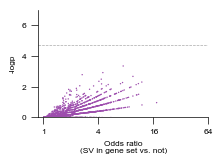

In [331]:
test_cat = "ANY.SINGLETON.ANY.neuroblastoma_tad_boundary.ANY.ANY.ANY.protein_coding"

palette = {'neuroblastoma': mc.palette['neuroblastoma']["main"],
           'ewing': mc.palette['ewing']["main"]}

fig, ax = plt.subplots(1, figsize=(2.2, 1.4))

coding_results = combined_gse_results.query('sv_category == "noncoding" & odds_ratio_cases_fisher > 1').copy()
coding_results["x_baseline"] = np.log2(coding_results["odds_ratio_cases_fisher"])
coding_results["y_baseline"] = -np.log10(coding_results["p_cases_fisher"])

data = coding_results.query(f'category == "{test_cat}"').copy()

nlp_bonf = -np.log10(p_bonf_cutoff)
data['size'] = np.where(data['y_baseline'] > nlp_bonf, 5, 1)
data['c'] = data['disease'].replace(palette)

# plot the significant ones first
sig = data.query(f'y_baseline > {nlp_bonf}')
points = ax.scatter(x = sig['x_baseline'], y = sig['y_baseline'], s = sig['size'], ec = None, c = sig['c'])

nonsig = data.query(f'y_baseline < {nlp_bonf}').sample(frac = 1)
for chunk in np.array_split(nonsig, 200):
    zorder = np.random.uniform()
    points = ax.scatter(x = chunk['x_baseline'], y = chunk['y_baseline'], s = chunk['size'], ec = None, c = chunk['c'])

sns.despine(ax=ax)
ax.set_xlim([None, 6])
ax.set_ylim([0, 7])
ax.axhline(
    y=nlp_bonf,
    linestyle="dashed",
    color="darkgrey",
    zorder=-1,
    linewidth = 0.5
)
ax.set_ylabel("-logp")
ax.set_xlabel("Odds ratio\n(SV in gene set vs. not)", fontsize = 6)

ax.set_xticks([0, 2, 4, 6])
ax.set_xticklabels([1, 4, 16, 64])

fig.savefig('images/neuroblastoma-tad-boundary-GSEA.pdf', bbox_inches = 'tight')